# Завдання
Використовуючи датасет `cardox.csv` виконайте наступну роботу:
1.	Виконайте попередній аналіз даних
2.	Скорегуйте виявлені аномалії
3.	Заповніть пропущені значення
4.	Проведіть декомпозицію часового ряду
5.	Побудуйте модель та оцініть її ефективність
6.	Проведіть кінцеву діагностику моделі
7.	Побудувати прогноз на 30 років
8.	Зберегти результати прогнозування у файл

## Рішення

### 1. Попередній аналіз даних

In [559]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from joypy import joyplot
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings('ignore')

In [560]:
df = pd.read_csv('cardox.csv', parse_dates=['date'])

In [561]:
df.head()

,date,value
0,1958-03-01,315.71
1,1958-04-01,317.45
2,1958-05-01,317.50
3,1958-06-01,317.10
4,1958-07-01,315.86


In [562]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    729 non-null    datetime64[ns]
 1   value   729 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 11.5 KB


In [563]:
df.describe()

,value
count,729.000000
mean,353.787229
std,27.547500
min,312.660000
25%,328.570000
50%,351.410000
75%,375.990000
max,411.240000


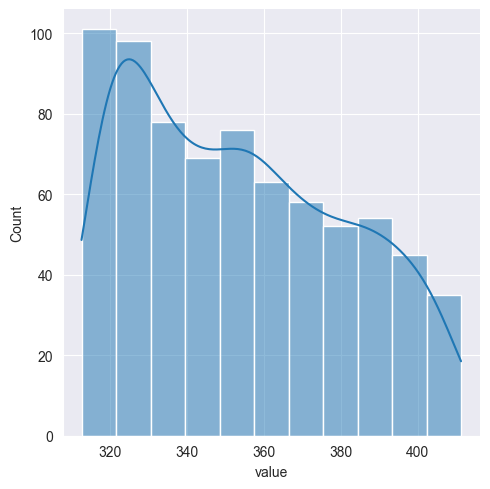

In [564]:
sns.displot(df.value, kde=True)

<AxesSubplot: xlabel='date', ylabel='value'>

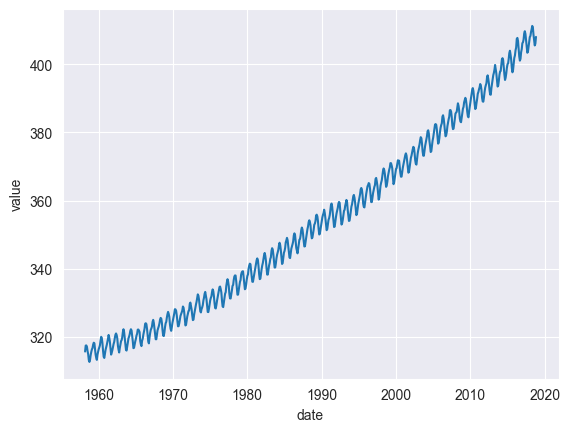

In [565]:
sns.lineplot(data=df, x='date', y='value')

Датасет містить 729 щомісячних даних. Він складається з одного стовпця з назвою `value`, який містить числові значення типу float64. Дублікатів та пропущених значень не має. Спостерігається  лінійний тренд, що росте (зростає), наявна сезонність.

### 2. Скорегуйте виявлені аномалії

In [566]:
df_m = df.copy()
df_m['month'] = df['date'].dt.month_name()
df_m

,date,value,month
0,1958-03-01,315.71,March
1,1958-04-01,317.45,April
2,1958-05-01,317.50,May
3,1958-06-01,317.10,June
4,1958-07-01,315.86,July
...,...,...,...
724,2018-07-01,408.71,July
725,2018-08-01,406.99,August
726,2018-09-01,405.51,September
727,2018-10-01,406.00,October


<Figure size 640x480 with 0 Axes>

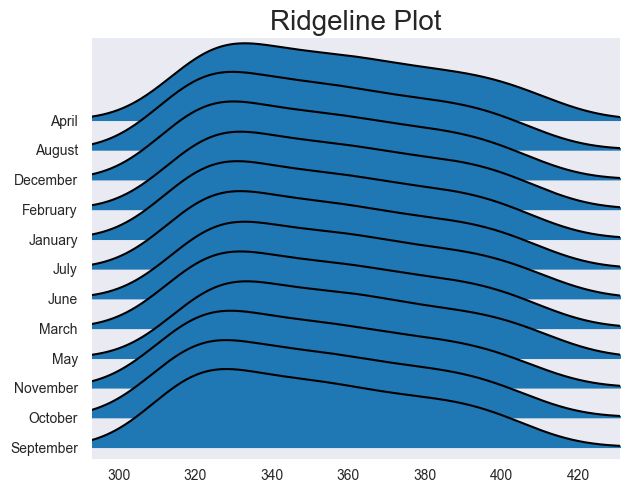

In [567]:
plt.figure()

joyplot(
    data=df_m[['value', 'month']],
    by='month'
)
plt.title('Ridgeline Plot', fontsize=20)
plt.show()

In [568]:
def run_isolation_forest(model_data: pd.DataFrame, contamination=0.005, n_estimators=200, max_samples=0.7) -> pd.DataFrame:

    IF = (IsolationForest(random_state=0,
                          contamination=contamination,
                          n_estimators=n_estimators,
                          max_samples=max_samples)
         )

    IF.fit(model_data)

    output = pd.Series(IF.predict(model_data)).apply(lambda x: 1 if x == -1 else 0)

    score = IF.decision_function(model_data)

    return output, score

In [569]:
df_m = df_m.set_index('date')

outliers, score = run_isolation_forest(df_m.drop('month', axis=1))
df_m = (df_m
      .assign(Outliers = outliers)
      .assign(Score = score)
      )

df_m.head()

,value,month,Outliers,Score
date,,,,
1958-03-01,315.71,March,NaN,0.120013
1958-04-01,317.45,April,NaN,0.153355
1958-05-01,317.50,May,NaN,0.154209
1958-06-01,317.10,June,NaN,0.150322
1958-07-01,315.86,July,NaN,0.125684


In [570]:
len(df_m.query("Outliers == 1"))

0

### 3. Пропущені значення

In [571]:
df['value'].isna().sum()

0

Пропусків у даних не має.

### 4.	Декомпозиція часового рядку

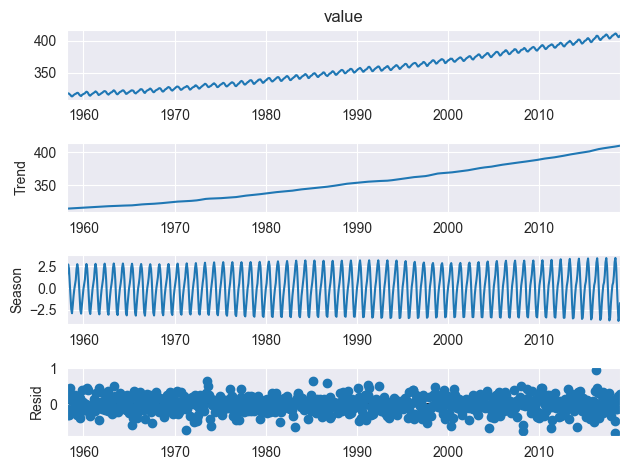

In [572]:
stl = STL(df_m['value'], seasonal=13)
res = stl.fit()
fig = res.plot()

### 5. Модель прогнозування

In [573]:
# Знайдемо оптимальні значення параметрів ARIMA моделі
model = auto_arima(df.value, seasonal=True,
                   stepwise=True, trace=True, m=12)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=467.687, Time=1.73 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=2369.532, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=1614.808, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2375.248, Time=0.01 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=1101.952, Time=1.66 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=770.631, Time=1.65 sec
 ARIMA(2,1,2)(2,0,1)[12] intercept   : AIC=506.266, Time=4.64 sec
 ARIMA(2,1,2)(1,0,2)[12] intercept   : AIC=531.891, Time=4.34 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=1440.918, Time=0.39 sec
 ARIMA(2,1,2)(0,0,2)[12] intercept   : AIC=inf, Time=3.94 sec
 ARIMA(2,1,2)(2,0,0)[12] intercept   : AIC=611.730, Time=4.48 sec
 ARIMA(2,1,2)(2,0,2)[12] intercept   : AIC=inf, Time=3.55 sec
 ARIMA(1,1,2)(1,0,1)[12] intercept   : AIC=454.795, Time=1.67 sec
 ARIMA(1,1,2)(0,0,1)[12] intercept   : A

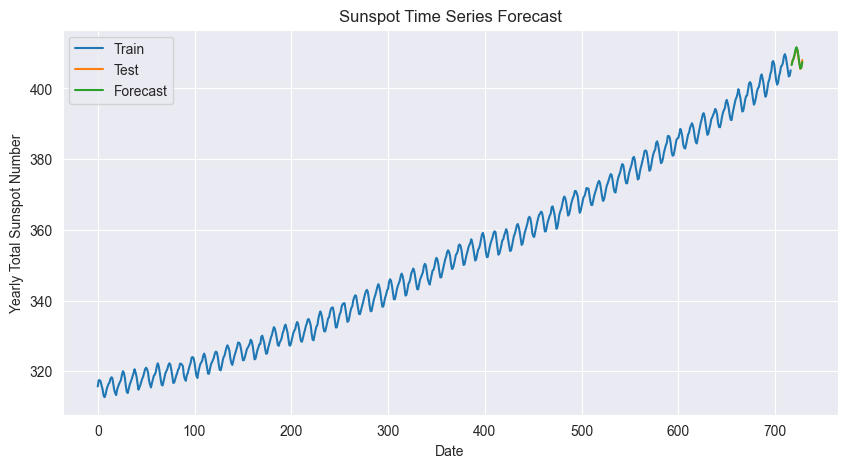

In [574]:
# Навчаємо модель на даних
train = df.iloc[:-12]
test = df.iloc[-12:]

model = ARIMA(train['value'], order=(2,1,1), seasonal_order=(1,0,1,12))
model_fit = model.fit()

# Прогнозуємо значення для тестового періоду
forecast = model_fit.forecast(len(test), alpha=0.05)

# Візуалізація прогнозу та реальних значень
plt.figure(figsize=(10,5))
plt.plot(train.index,train['value'], label='Train')
plt.plot(test.index,test['value'], label='Test')
plt.plot(test.index,forecast, label='Forecast')
plt.xlabel('Date')
plt.ylabel('Yearly Total Sunspot Number')
plt.title('Sunspot Time Series Forecast')
plt.legend()
plt.show()

### 6. Кінцева діагностика моделі

In [575]:
# Прогнозуємо значення на весь доступний період
forecast = model_fit.forecast(len(test), alpha=0.05)

# Обчислюємо метрики
mae = mean_absolute_error(test['value'], forecast)
rmse = np.sqrt(mean_squared_error(test['value'], forecast))

print('MAE:', mae)
print('MSE:', rmse)

MAE: 0.2747328121482866
MSE: 0.35688158261680886


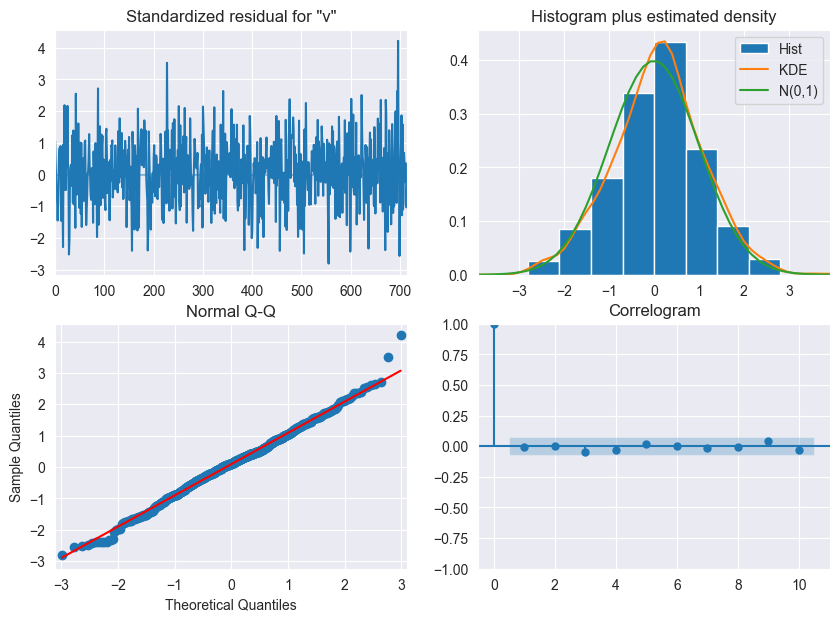

In [576]:
fig = model_fit.plot_diagnostics(figsize=(10,7))

Залишки моделі не автокорельовані, близькі до нормального розподілу та виглядають, як білий шум. Значення залишків досить мале. Отже модель добре оцінює наші дані та має давати досить точні прогнози.

### 7. Побудувати прогноз на 30 років

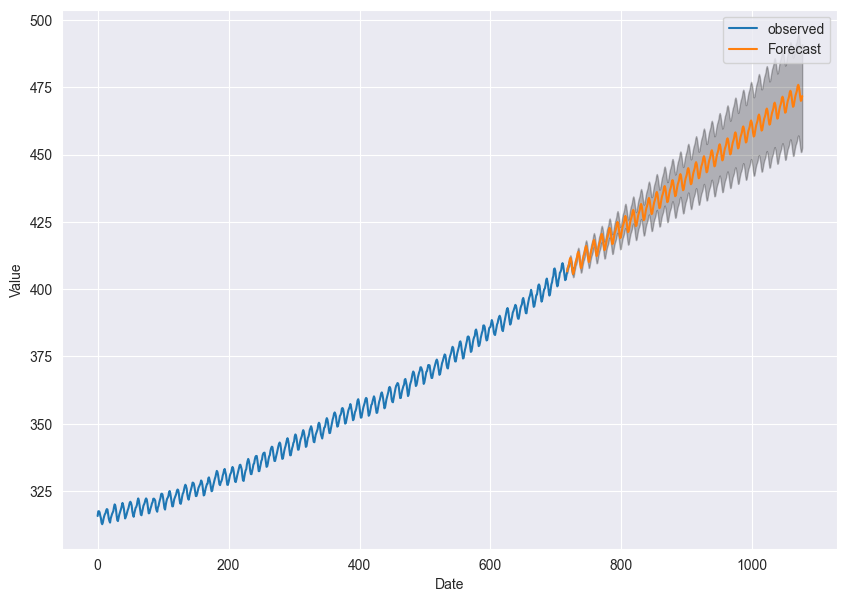

In [577]:
# Прогнозуємо значення на весь доступний період
pred_uc = model_fit.get_forecast(steps=30*12)
pred_ci = pred_uc.conf_int()

ax = df['value'].plot(label='observed', figsize=(10, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Value')

plt.legend()
plt.show()

### 8.	Зберегти результати прогнозування у файл

In [578]:
predict_df = pd.DataFrame({'Predict': pred_uc.predicted_mean,
                           'Low': pred_ci['lower value'],
                           'Up': pred_ci['upper value']})
predict_df.to_csv('predict_df.csv')